In [1]:
import torch
import torch.nn.functional as F
import kornia.color as K
import numpy as np
 
from torch.utils.data import DataLoader
import sys
import os
# 添加SAFNet根目录到Python路径
root_dir = '/root/autodl-tmp/diffIRhdr'
if root_dir not in sys.path:
    sys.path.append(root_dir)

# 然后再导入HDRDataset
from dataset.datasets import HDRDataset

val_dir = '/root/autodl-tmp/diffIRhdr/dataset/ka17'
val_dataset = HDRDataset(val_dir,patch_size=1,is_train=False)  
val_loader = DataLoader(val_dataset, batch_size=1,shuffle=False,drop_last=False)
# Get specific index from validation loader
def get_test_image(index=8):
    imgs_lin, imgs_ldr, expos, gt, = val_dataset[index]
    return torch.from_numpy(imgs_ldr[0]).unsqueeze(0), torch.from_numpy(imgs_ldr[1]).unsqueeze(0)


15


In [2]:
source, reference = get_test_image(index=13)

In [7]:
from utils.mask_util.hdr_mask import average_filter, detect_exposure_regions, match_brightness, morphological_opening
import matplotlib.pyplot as plt

def get_diff_mask(source, reference,
                          kernel_size=9,threshold=0.9,
                          eroded_kernel_size=11,
                          dilated_kernel_size=11,percentile=0.04):
    # 1. Average filtering
    source_avg = average_filter(source,kernel_size=kernel_size)
    reference_avg = average_filter(reference,kernel_size=kernel_size)
    
    # 2. Brightness matching
    source_matched = match_brightness(source_avg, reference_avg)
    
    # 3. Exposure detection
    under_exposed, over_exposed = detect_exposure_regions(source_matched,percentile=percentile)
    
    # 4. Difference calculation
    diff = torch.abs(source_matched - reference_avg)
    diff_mean = diff.mean(dim=1, keepdim=True) # [B,1,H,W]
    
    # Find threshold for top percentage
    #threshold = torch.quantile(diff_mean.flatten(), threshold)
    
    # 5. Create binary mask for differences above threshold
    mask = (diff_mean > threshold).float()
    
    # 6. Combine with exposure masks
    combined_mask = torch.clamp(mask + under_exposed.unsqueeze(1) + over_exposed.unsqueeze(1), 0, 1)
    
    # 7. Morphological opening
    final_mask = morphological_opening(combined_mask, eroded_kernel_size=eroded_kernel_size, dilated_kernel_size=dilated_kernel_size)

    # Visualize all stages
    plt.figure(figsize=(15, 5))
    
    plt.subplot(151)
    plt.imshow(source_matched[0].permute(1,2,0).cpu().numpy())
    plt.title('Brightness Matched')
    plt.axis('off')
    
    plt.subplot(152)
    plt.imshow(under_exposed[0].cpu().numpy(), cmap='gray')
    plt.title('Under Exposed Mask')
    plt.axis('off')
    
    plt.subplot(153)
    plt.imshow(over_exposed[0].cpu().numpy(), cmap='gray')
    plt.title('Over Exposed Mask')
    plt.axis('off')
    
    plt.subplot(154)
    plt.imshow(mask[0,0].cpu().numpy(), cmap='gray')
    plt.title('Difference Mask')
    plt.axis('off')
    
    plt.subplot(155)
    plt.imshow(final_mask[0,0].cpu().numpy(), cmap='gray')
    plt.title('Final Mask')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return final_mask[:,0:1] # Only return single channel [B,1,H,W]

torch.Size([1, 3, 1000, 1500])


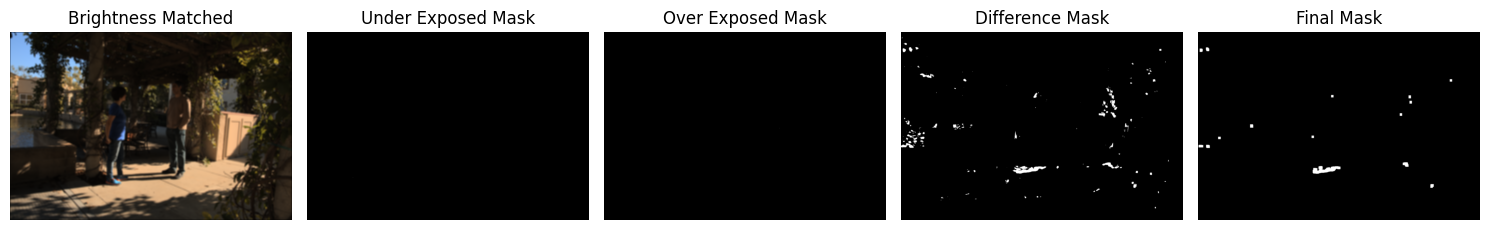

In [14]:
import numpy as np
from PIL import Image

from utils.mask_util.hdr_mask import match_brightness
img_path = "/root/autodl-tmp/diffIRhdr/img_hdr_pred_siggraph17/014.png"
gt_path = "/root/autodl-tmp/diffIRhdr/img_hdr_pred_siggraph17/014_gt.png"

img = Image.open(img_path)
img = torch.from_numpy(np.array(img)).permute(2,0,1).unsqueeze(0).float() / 255.0
reference = img
gt = Image.open(gt_path)
gt = torch.from_numpy(np.array(gt)).permute(2,0,1).unsqueeze(0).float() / 255.0
source = gt
reference = reference.to("cuda")
source = source.to("cuda")

print(source.shape)
diff_mask = get_diff_mask(source, reference,
                          kernel_size=11,threshold=0.01,
                          eroded_kernel_size=11,
                          dilated_kernel_size=13,percentile=0.00)



Mask ratio: 1.71%


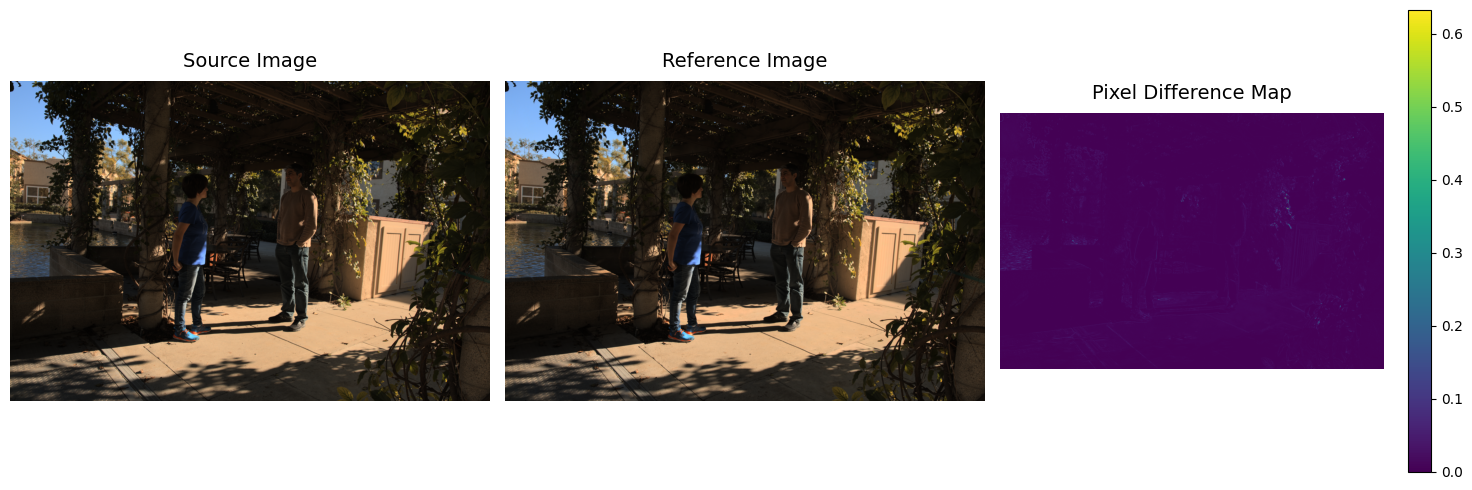

Average pixel difference: 0.0046


In [49]:

# Calculate mask ratio (percentage of white pixels)
mask_ratio = diff_mask.mean().item()
print(f"Mask ratio: {mask_ratio:.2%}")

# Calculate absolute difference between source and reference
diff = torch.abs(source - reference)
diff_mean = diff.mean(dim=1, keepdim=True)  # Average across channels to get single channel

plt.figure(figsize=(15, 5))

plt.subplot(131)
plt.imshow(source[0].permute(1,2,0).cpu().numpy())
plt.title('Source Image', fontsize=14, pad=10)
plt.axis('off')

plt.subplot(132) 
plt.imshow(reference[0].permute(1,2,0).cpu().numpy())
plt.title('Reference Image', fontsize=14, pad=10)
plt.axis('off')

plt.subplot(133)
plt.imshow(diff_mean[0,0].cpu().numpy(), cmap='viridis')
plt.colorbar()
plt.title('Pixel Difference Map', fontsize=14, pad=10)
plt.axis('off')

plt.tight_layout()
plt.show()

# Print average difference
print(f"Average pixel difference: {diff_mean.mean().item():.4f}")


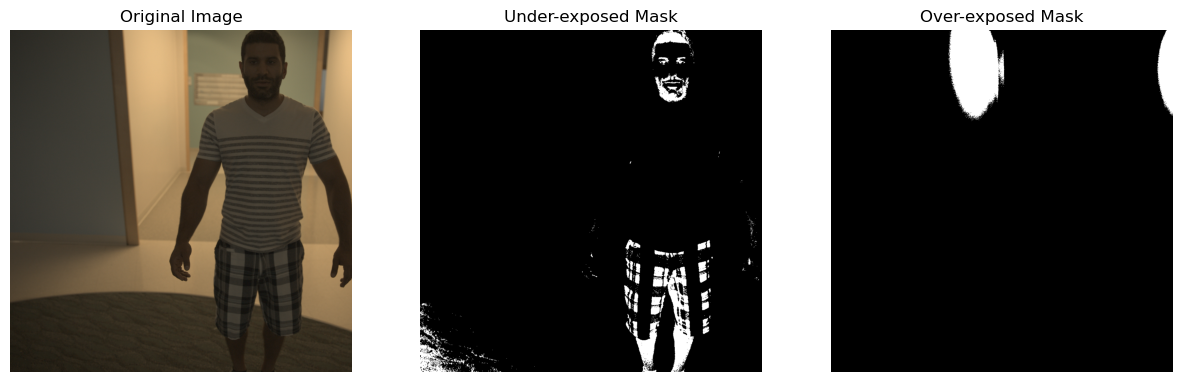

Under-exposed ratio: 4.00%
Over-exposed ratio: 4.00%


In [18]:
from hdr_mask import detect_exposure_regions

under_exposed, over_exposed = detect_exposure_regions(source,percentile=0.04)
plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.imshow(source[0].permute(1,2,0).cpu().numpy())
plt.title('Original Image')
plt.axis('off')

plt.subplot(132)
plt.imshow(under_exposed[0].cpu().numpy(), cmap='gray')
plt.title('Under-exposed Mask')
plt.axis('off')

plt.subplot(133)
plt.imshow(over_exposed[0].cpu().numpy(), cmap='gray')
plt.title('Over-exposed Mask')
plt.axis('off')

plt.show()

# Calculate mask ratios
under_ratio = under_exposed.mean().item()
over_ratio = over_exposed.mean().item()
print(f"Under-exposed ratio: {under_ratio:.2%}")
print(f"Over-exposed ratio: {over_ratio:.2%}")
